In [1]:
# Import our dependencies
import warnings
warnings.filterwarnings("ignore")

import keras_tuner as kt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow.keras as keras

#  Import and read the charity_data.csv.
import pandas as pd 
ekg_db = pd.read_csv("ptbxl_database.csv")
ekg_db.head(3)

2024-02-29 11:11:27.160096: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


,ecg_id,patient_id,age,sex,height,weight,nurse,site,device,recording_date,...,validated_by_human,baseline_drift,static_noise,burst_noise,electrodes_problems,extra_beats,pacemaker,strat_fold,filename_lr,filename_hr
0,1,15709.0,56.0,1,NaN,63.0,2.0,0.0,CS-12 E,1984-11-09 09:17:34,...,True,NaN,", I-V1,",NaN,NaN,NaN,NaN,3,records100/00000/00001_lr,records500/00000/00001_hr
1,2,13243.0,19.0,0,NaN,70.0,2.0,0.0,CS-12 E,1984-11-14 12:55:37,...,True,NaN,NaN,NaN,NaN,NaN,NaN,2,records100/00000/00002_lr,records500/00000/00002_hr
2,3,20372.0,37.0,1,NaN,69.0,2.0,0.0,CS-12 E,1984-11-15 12:49:10,...,True,NaN,NaN,NaN,NaN,NaN,NaN,5,records100/00000/00003_lr,records500/00000/00003_hr


In [2]:
# Drop the non-beneficial columns
ekg_db.drop(columns = ['patient_id', 'recording_date', 'report', 'filename_hr',
                      'filename_lr', 'strat_fold', 'pacemaker', 'extra_beats',
                      'electrodes_problems', 'burst_noise', 'static_noise', 
                      'baseline_drift', 'validated_by_human', 'initial_autogenerated_report',
                      'second_opinion','heart_axis',
                      'infarction_stadium1', 'infarction_stadium2', 'site',
                      'nurse'], inplace=True)
ekg_db

,ecg_id,age,sex,height,weight,device,scp_codes,validated_by
0,1,56.0,1,NaN,63.0,CS-12 E,"{'NORM': 100.0, 'LVOLT': 0.0, 'SR': 0.0}",NaN
1,2,19.0,0,NaN,70.0,CS-12 E,"{'NORM': 80.0, 'SBRAD': 0.0}",NaN
2,3,37.0,1,NaN,69.0,CS-12 E,"{'NORM': 100.0, 'SR': 0.0}",NaN
3,4,24.0,0,NaN,82.0,CS-12 E,"{'NORM': 100.0, 'SR': 0.0}",NaN
4,5,19.0,1,NaN,70.0,CS-12 E,"{'NORM': 100.0, 'SR': 0.0}",NaN
...,...,...,...,...,...,...,...,...
21794,21833,67.0,1,NaN,NaN,AT-60 3,"{'NDT': 100.0, 'PVC': 100.0, 'VCLVH': 0.0, 'ST...",1.0
21795,21834,300.0,0,NaN,NaN,AT-60 3,"{'NORM': 100.0, 'ABQRS': 0.0, 'SR': 0.0}",1.0
21796,21835,59.0,1,NaN,NaN,AT-60 3,"{'ISCAS': 50.0, 'SR': 0.0}",1.0
21797,21836,64.0,1,NaN,NaN,AT-60 3,"{'NORM': 100.0, 'SR': 0.0}",1.0


In [3]:
# Split the "scp_codes"
for i in range(len(ekg_db)):
       ekg_db["scp_codes"][i] = ekg_db["scp_codes"][i].split("'")[1]
     
ekg_db["scp_codes"]

0         NORM
1         NORM
2         NORM
3         NORM
4         NORM
         ...  
21794      NDT
21795     NORM
21796    ISCAS
21797     NORM
21798     NORM
Name: scp_codes, Length: 21799, dtype: object

In [4]:
# Create dummies dataset
ekg_dummies = pd.get_dummies(ekg_db)
ekg_dummies.head(3)

,ecg_id,age,sex,height,weight,validated_by,device_AT-6 6,device_AT-6 C,device_AT-6 C 5.0,device_AT-6 C 5.3,...,scp_codes_PACE,scp_codes_PMI,scp_codes_PSVT,scp_codes_PVC,scp_codes_RAO/RAE,scp_codes_RVH,scp_codes_SEHYP,scp_codes_SR,scp_codes_STACH,scp_codes_WPW
0,1,56.0,1,NaN,63.0,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
1,2,19.0,0,NaN,70.0,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,3,37.0,1,NaN,69.0,NaN,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [228]:
# Clean dummies dataset
dummies_clean = ekg_dummies[['ecg_id','age', 'sex', 'weight', 'scp_codes_NORM']]
dummies_clean.head(3)

,ecg_id,age,sex,weight,scp_codes_NORM
0,1,56.0,1,63.0,True
1,2,19.0,0,70.0,True
2,3,37.0,1,69.0,True


In [229]:
# Drop NA columns
dummies_clean = dummies_clean.dropna()
dummies_clean.head(3)

,ecg_id,age,sex,weight,scp_codes_NORM
0,1,56.0,1,63.0,True
1,2,19.0,0,70.0,True
2,3,37.0,1,69.0,True


In [231]:
# Split our preprocessed data into our features and target arrays
X = dummies_clean.drop('scp_codes_NORM', axis=1).values
y = dummies_clean['scp_codes_NORM'].values

# Split the preprocessed data into a training and testing dataset
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42)

In [232]:
# Create a StandardScaler instances
scaler = StandardScaler()

# Fit the StandardScaler
X_scaler = scaler.fit(X_train)

# Scale the data
X_train_scaled = X_scaler.transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

In [233]:
# Get the input feature/ shape
X_train_scaled.shape
input_features = X_train_scaled.shape[1]

In [234]:
y = y.reshape(-1,1)

In [235]:
# Define the model - deep neural net, i.e., the number of input features and hidden nodes for each layer.
input_features = len(X_train_scaled[0])
hidden_nodes1 = 40
hidden_nodes2 =20

# Add a third hidden layer
hidden_nodes3 =10
hidden_nodes4 = 5

nn_2 = tf.keras.models.Sequential()

# First hidden layer
nn_2.add(tf.keras.layers.Dense(units=hidden_nodes1,activation='relu',input_dim=input_features))

# Second hidden layer
nn_2.add(tf.keras.layers.Dense(units=hidden_nodes2,activation='sigmoid'))

# Third hidden layer
nn_2.add(tf.keras.layers.Dense(units=hidden_nodes3,activation='sigmoid'))

# # Fourth hidden layer
nn_2.add(tf.keras.layers.Dense(units=hidden_nodes3,activation='sigmoid'))

# Output layer
nn_2.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

# Check the structure of the model
nn_2.summary()

Model: "sequential_45"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_207 (Dense)           (None, 40)                200       
                                                                 
 dense_208 (Dense)           (None, 20)                820       
                                                                 
 dense_209 (Dense)           (None, 10)                210       
                                                                 
 dense_210 (Dense)           (None, 10)                110       
                                                                 
 dense_211 (Dense)           (None, 1)                 11        
                                                                 
Total params: 1351 (5.28 KB)
Trainable params: 1351 (5.28 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [236]:
# Compile the model
nn_2.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])

# Train the model
fit_model = nn_2.fit(X_train_scaled,y_train,epochs=25)

Epoch 1/25
221/221 [==============================] - 1s 1ms/step - loss: 0.2601 - accuracy: 1.0000
Epoch 2/25
221/221 [==============================] - 0s 1ms/step - loss: 0.0571 - accuracy: 1.0000
Epoch 3/25
221/221 [==============================] - 0s 1ms/step - loss: 0.0272 - accuracy: 1.0000
Epoch 4/25
221/221 [==============================] - 0s 1ms/step - loss: 0.0163 - accuracy: 1.0000
Epoch 5/25
221/221 [==============================] - 0s 1ms/step - loss: 0.0108 - accuracy: 1.0000
Epoch 6/25
221/221 [==============================] - 0s 1ms/step - loss: 0.0075 - accuracy: 1.0000
Epoch 7/25
221/221 [==============================] - 0s 1ms/step - loss: 0.0055 - accuracy: 1.0000
Epoch 8/25
221/221 [==============================] - 0s 1ms/step - loss: 0.0042 - accuracy: 1.0000
Epoch 9/25
221/221 [==============================] - 0s 1ms/step - loss: 0.0033 - accuracy: 1.0000
Epoch 10/25
221/221 [==============================] - 0s 1ms/step - loss: 0.0027 - accuracy: 1.0000

In [210]:
# Evaluate the model using the test data
model_loss, model_accuracy = nn_2.evaluate(X_test_scaled,y_test,verbose=2)
print(f"Loss: {model_loss}, Accuracy: {model_accuracy}")

74/74 - 0s - loss: 0.5531 - accuracy: 0.7165 - 181ms/epoch - 2ms/step
Loss: 0.553139328956604, Accuracy: 0.7164685726165771


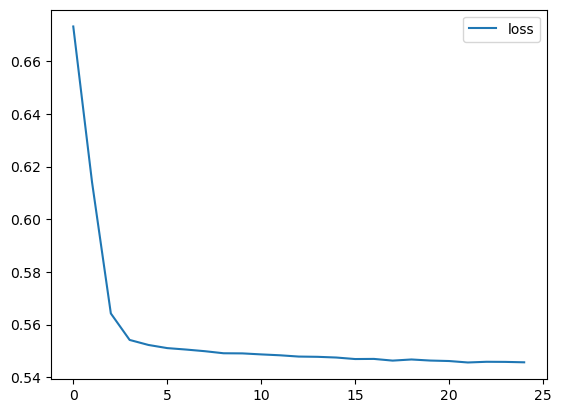

In [143]:
history_df = pd.DataFrame(fit_model.history)
history_df.plot(y="loss")
plt.show()

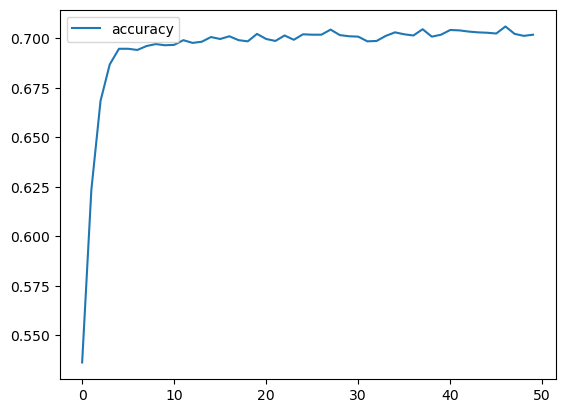

In [141]:
history_df.plot(y='accuracy')
plt.show()

In [91]:
prediction = nn_2.predict(X_test_scaled[0].reshape(1,-1))
prediction

1/1 [==============================] - 0s 50ms/step


array([[0.46209535]], dtype=float32)